# Accident dataset creation

### Process Flow :

1. load file from Internet and create pickle snapshot in case dataset site off-line  
2. filter and enrich with postcode data  
3. create pickle snapshot of enriched file for downstream use  
4. reload preprocessed data and check details

### Input data

Accident data: from https://data.gov.uk/dataset/road-accidents-safety-data  
**Accidents_FLM.csv**: from /Specs directory  
**Postcode dataset**: from /Data directory; generated by RTA_DS_Postcodes

### Output data

* 'Accidents_2015.pickle': snapshot of Accidents source data
* 'Accidents_cleaned.pickle': filtered Accidents data
* 'Accidents.pickle' : **Accidents dataset** - including postcode enriched data
* saved data assessment plot (.png) snapshots

## Import external libraries

In [1]:
'''
RTA Accidents required imports
'''
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

## 'Import' RTAutilities

In [2]:
'''
Provide output of csv and pickle formats for DataFrames
'''
def pick_and_csv(df, path, filename):
    import sys
    try:
        df.to_csv(path + filename + '.csv', index=False)
        df.to_pickle(path + filename + '.pickle')
    except IOError as (errno, strerror):
        print ('I/O error({0}): {1}'.format(errno, strerror))
        if errno == 13:
            print ('*** check to see if (someone has) file already open ***')
        elif errno == 2:
            print ('Directory parameter needs to be a valid directory')
    except:
        print ("Unexpected error:", sys.exc_info()[0])
        print ('*** is first parameter a DataFrame? ***')
        raise

## Load Accident data and create dataset

In [3]:
'''
Load accident data - need to download accident file to local Data diectory

'''
start_time0 = time.time()

#load Accident file from url
url='http://data.dft.gov.uk/road-accidents-safety-data/RoadSafetyData_Accidents_2015.zip'
Accidents = pd.read_csv(url, compression='zip', sep=',', quotechar='"', engine = 'python')

#Save Accident data as a csv and pickle file
_ = pick_and_csv(Accidents, 'Data/', 'Accidents_2015')

print ("Accidents dataload from website: %s seconds " % (time.time() - start_time0))

Accidents dataload from website: 13.1849999428 seconds 


In [4]:
start_time0 = time.time()

#load 'Field Load Map' specification
pfl = pd.read_csv('Specs/Accidents_FLM.csv',low_memory=False)
pc_cols_rename = dict(pfl[['field_name','field_descriptor']].where(pfl['import']=='Y').dropna().values.tolist())
pc_cols_drop = pfl['field_name'].where(pfl['import']=='N').dropna().values.tolist()

#clean data
Accidents.drop(pc_cols_drop, axis=1, inplace=True) #drop columns based on loaded 'FLM' spec
Accidents.rename(columns=pc_cols_rename, inplace=True) #rename columns to lower case and no spaces based on 'FLM' spec
Accidents = Accidents[Accidents.latitude.notnull()] #drop accidents with no lat/long coordinates

#Add latitude and longitude 'areas' to provide lookup of postcode 
Accidents['Acc_coord'] = zip(Accidents['latitude'], Accidents['longitude'])

#Save Accident data as a csv and pickle file
_ = pick_and_csv(Accidents, 'Data/', 'Accidents_cleaned')

print ("Accidents dataset preparation: %s seconds " % (time.time() - start_time0))

Accidents dataset preparation: 4.79299998283 seconds 


In [5]:
'''
Postcode enrichment
                        ***** WARNING! This takes over 10 hours to run on a CPU!! *****
                        *****          Postcode lookup: 38845.28 seconds          *****
'''
def get_postcode(Acc_coord):
    from haversine import haversine 
    d = [[99999,99999]]
    for Pindex, Prow in Postcodes.iterrows():
        d.append([abs(haversine(Prow['Post_coord'],Acc_coord)),Pindex])
    return Postcodes.iloc[min(d)[1]][1]

start_time0 = time.time()

Postcodes = pd.read_pickle('Data/Postcodes.pickle')

Accidents['Postcode'] = Accidents['Acc_coord'].apply(lambda x: get_postcode(x)) #works but needs performance tuning
Accidents['Areas'] = Accidents['Postcode'].str.extract(r'(\D+)')

_ = pick_and_csv(Accidents, 'Data/', 'Accidents')

print ("Postcode lookup: %s seconds" % (time.time() - start_time0))

C:\Users\Iain\Anaconda3\envs\GA\lib\site-packages\ipykernel\__main__.py:18: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


Postcode lookup: 31661.352 seconds


## Data assessment

In [6]:
'''
Reload RTA Accidents and Postcodes dataframes to check properly saved and reloadable
'''
Accidents = pd.read_pickle('Data/Accidents.pickle')
Postcodes = pd.read_pickle('Data/Postcodes_out.pickle')
#Accidents = pd.read_pickle('Data/Accidents_2015.pickle')
#Accidents = pd.read_pickle('Data/Accidents_backup.pickle')

In [7]:
Accidents.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140029 entries, 0 to 140055
Data columns (total 35 columns):
accident_index                                 140029 non-null object
location_easting_osgr                          140029 non-null float64
location_northing_osgr                         140029 non-null float64
longitude                                      140029 non-null float64
latitude                                       140029 non-null float64
police_force                                   140029 non-null int64
accident_severity                              140029 non-null int64
number_of_vehicles                             140029 non-null int64
number_of_casualties                           140029 non-null int64
date                                           140029 non-null object
day_of_week                                    140029 non-null int64
time                                           140011 non-null object
local_authority_(district)                     140

In [8]:
Accidents.tail(2)

,accident_index,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,...,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,lsoa_of_accident_location,Acc_coord,Postcode,Areas
140054,2015984140515,328273.0,570137.0,-3.123385,55.020580,98,3,3,3,26/12/2015,...,2,2,0,0,2,1,NaN,"(55.02058, -3.123385)",DG16,DG
140055,2015984141415,314050.0,579638.0,-3.348646,55.103676,98,3,13,7,31/12/2015,...,3,4,0,0,2,1,NaN,"(55.103676, -3.348646)",DG11,DG


In [9]:
Postcodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3003 entries, 0 to 3002
Data columns (total 4 columns):
id           3003 non-null int64
postcode     3003 non-null object
latitude     3003 non-null float64
longitude    3003 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 93.9+ KB


In [10]:
Postcodes.head(2)

,id,postcode,latitude,longitude
0,2,AB10,57.13514,-2.11731
1,3,AB11,57.13875,-2.09089


C:\Users\Iain\Anaconda3\envs\GA\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


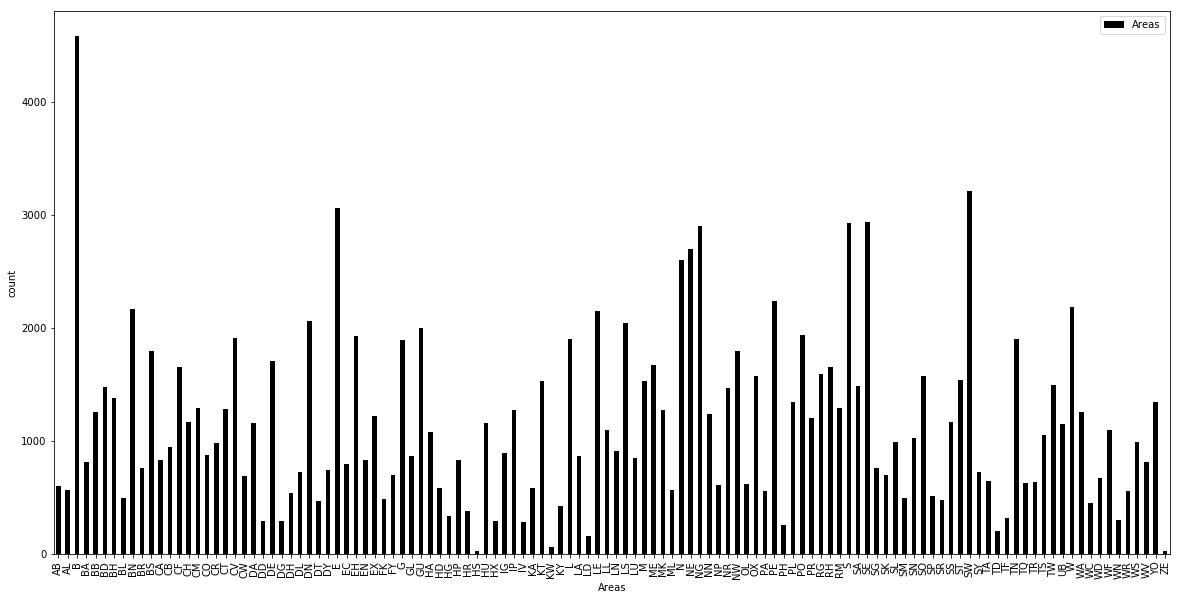

In [11]:
'''
RTA Accident check data fields
'''

Accidents['Areas'] = Accidents['Postcode'].str.extract(r'(\D+)')
# check data
col = 'Areas'

plt.figure(figsize=(20,10))
Accidents.groupby([col])[col].count().plot(kind='bar',color='k',legend=True)
plt.ylabel('count')
plt.savefig('Data/Pics/Accidents_Bar_'+col+'.png')
plt.show()

In [12]:
AC = pd.DataFrame([])
AC['Areas'] = Accidents['Postcode'].str.extract(r'(\D+)')
AC['AC_Count'] = 1
AC['AC_Count'] = AC['AC_Count'].astype(np.int)
AC_C = AC.groupby(['Areas']).sum()
AC_C.head()

C:\Users\Iain\Anaconda3\envs\GA\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  from ipykernel import kernelapp as app


,AC_Count
Areas,
AB,602
AL,569
B,4580
BA,814
BB,1254


In [13]:
PC = pd.DataFrame([])
PC['Areas'] = Postcodes['postcode'].str.extract(r'(\D+)')
PC['PC_Count'] = 1
PC['PC_Count'] = PC['PC_Count'].astype(np.int)
PC_C = PC.groupby(['Areas']).sum()
PC_C.head()

C:\Users\Iain\Anaconda3\envs\GA\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  from ipykernel import kernelapp as app


,PC_Count
Areas,
AB,34
AL,10
B,78
BA,19
BB,14


In [14]:
PCAC_C = pd.concat([PC_C, AC_C], axis=1)
PCAC_C = PCAC_C.fillna(0)
PCAC_C['AC_Count'] = PCAC_C['AC_Count'].astype(np.int)
PCAC_C.head()

,PC_Count,AC_Count
AB,34,602
AL,10,569
B,78,4580
BA,19,814
BB,14,1254


In [15]:
PCAC_C['Ratio'] = PCAC_C.AC_Count / PCAC_C.PC_Count
PCAC_C.head()

,PC_Count,AC_Count,Ratio
AB,34,602,17.705882
AL,10,569,56.900000
B,78,4580,58.717949
BA,19,814,42.842105
BB,14,1254,89.571429


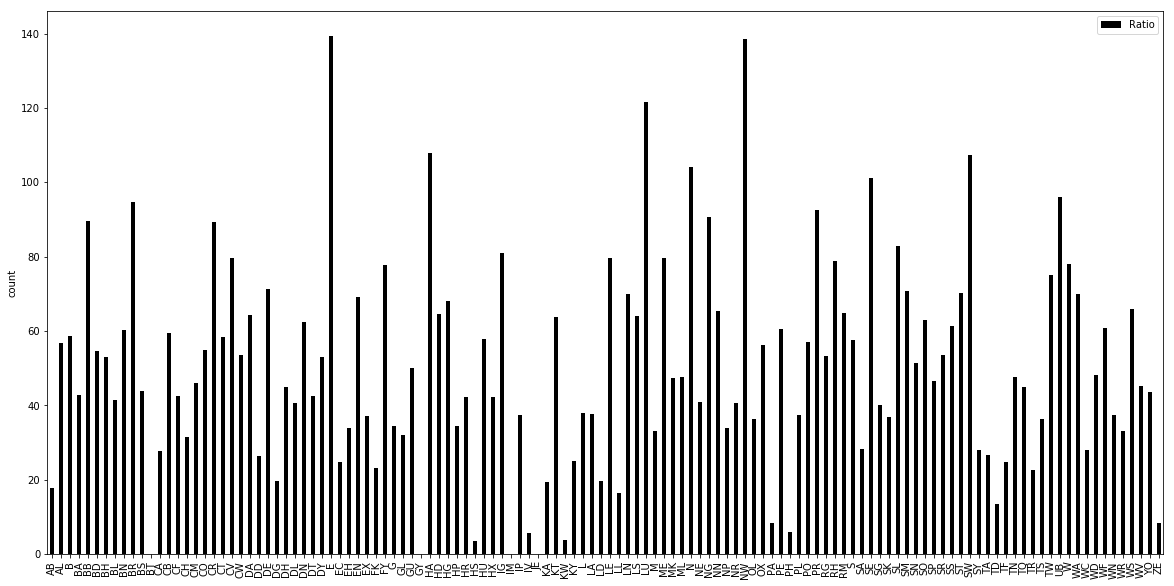

In [16]:
# check data
col = 'Ratio'

plt.figure(figsize=(20,10))
PCAC_C[col].plot(kind='bar',color='k',legend=True)
plt.ylabel('count')
plt.savefig('Data/Pics/Accidents_Bar_'+col+'.png')
plt.show()

In [17]:
#Accidents['Greenwich_vector'] = Accidents['Acc_coord'].apply(lambda x: calc_distance_and_bearing(x))